<a href="https://colab.research.google.com/github/sada95/IA/blob/master/voice_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

**Importer le jeu de données des commandes vocales**

Vous allez écrire un script pour télécharger une partie du jeu de données Speech Commands . L'ensemble de données original se compose de plus de 105 000 fichiers audio WAV de personnes prononçant trente mots différents. Ces données ont été collectées par Google et publiées sous une licence CC BY, et vous pouvez contribuer à les améliorer en contribuant cinq minutes de votre propre voix .

Vous utiliserez une partie de l'ensemble de données pour gagner du temps avec le chargement des données. Extrayez le mini_speech_commands.zip et chargez-le en utilisant l'API tf.data .

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 4s 0us/step


Vérifiez les statistiques de base sur l'ensemble de données.

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'stop' 'down' 'yes' 'up' 'go' 'left' 'right']


Extrayez les fichiers audio dans une liste et mélangez-la.

In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/stop/187af8be_nohash_0.wav', shape=(), dtype=string)


Divisez les fichiers en ensembles de formation, de validation et de test en utilisant un rapport 80:10:10, respectivement.

In [8]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


**Lire des fichiers audio et leurs étiquettes**

Le fichier audio sera initialement lu comme un fichier binaire, que vous voudrez convertir en un tenseur numérique.

Pour charger un fichier audio, vous utiliserez tf.audio.decode_wav , qui renvoie l'audio encodé en WAV en tant que Tensor et la fréquence d'échantillonnage.

Un fichier WAV contient des données de série chronologique avec un nombre défini d'échantillons par seconde. Chaque échantillon représente l'amplitude du signal audio à ce moment précis. Dans un système 16 bits, comme les fichiers dans mini_speech_commands , les valeurs vont de -32768 à 32767. La fréquence d'échantillonnage pour cet ensemble de données est de 16 kHz. Notez que tf.audio.decode_wav normalisera les valeurs dans la plage [-1,0, 1,0].

In [9]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

Le libellé de chaque fichier WAV est son répertoire parent.

In [10]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

Définissons une méthode qui prendra le nom de fichier du fichier WAV et affichera un tuple contenant l'audio et les étiquettes pour l'entraînement supervisé.

In [12]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Vous allez maintenant appliquer process_path pour créer votre ensemble d'entraînement afin d'extraire les paires d'étiquettes audio et de vérifier les résultats. Vous allez créer les ensembles de validation et de test en utilisant une procédure similaire plus tard.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Examinons quelques formes d'onde audio avec leurs étiquettes correspondantes.

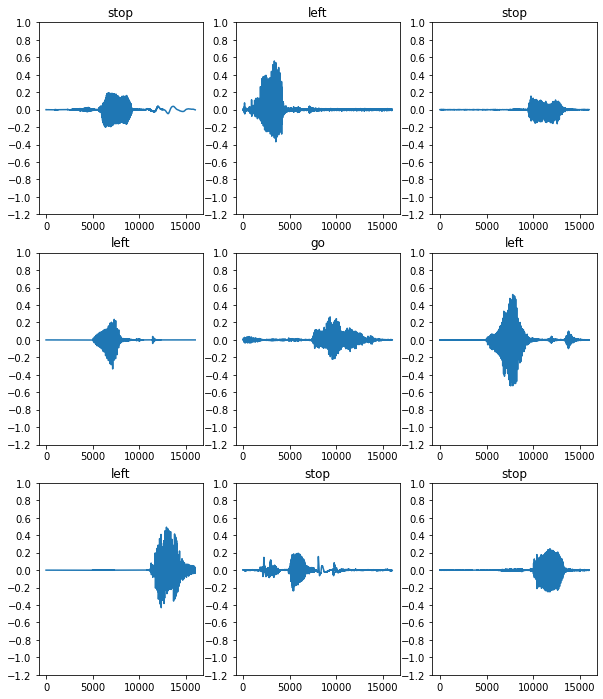

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Spectrogramme
Vous allez convertir la forme d'onde en un spectrogramme, qui montre les changements de fréquence au fil du temps et peut être représenté comme une image 2D. Cela peut être fait en appliquant la transformée de Fourier à court terme (STFT) pour convertir l'audio dans le domaine temps-fréquence.

Une transformée de Fourier ( tf.signal.fft ) convertit un signal en ses fréquences composantes, mais perd toutes les informations de temps. Le tf.signal.stft ( tf.signal.stft ) divise le signal en fenêtres de temps et exécute une transformée de Fourier sur chaque fenêtre, en préservant certaines informations de temps et en renvoyant un tenseur 2D sur lequel vous pouvez exécuter des convolutions standard.

STFT produit un tableau de nombres complexes représentant la magnitude et la phase. Cependant, vous n'aurez besoin que de l'ampleur de ce didacticiel, qui peut être dérivée en appliquant tf.abs sur la sortie de tf.signal.stft .

Choisissez les paramètres frame_length et frame_step sorte que le spectrogramme généré "image" soit presque carré. Pour plus d'informations sur le choix des paramètres STFT, vous pouvez vous référer à cette vidéo sur le traitement du signal audio.

Vous voulez également que les formes d'onde aient la même longueur, de sorte que lorsque vous les convertissez en une image spectrogramme, les résultats auront des dimensions similaires. Cela peut être fait simplement en remplissant à zéro les clips audio de moins d'une seconde.

In [23]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

Ensuite, vous explorerez les données. Comparez la forme d'onde, le spectrogramme et l'audio réel d'un exemple de l'ensemble de données.

In [24]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


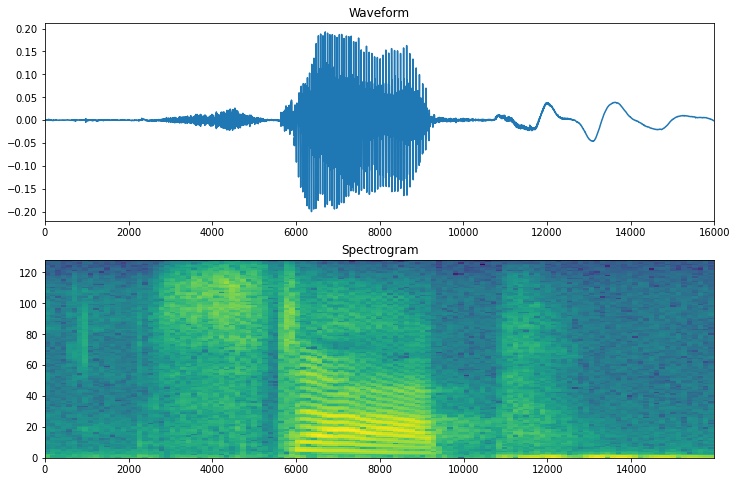

In [25]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Transformez maintenant le jeu de données de forme d'onde pour avoir des images de spectrogramme et leurs étiquettes correspondantes en tant qu'ID entiers.

In [26]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [27]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examinez les "images" du spectrogramme pour différents échantillons de l'ensemble de données.

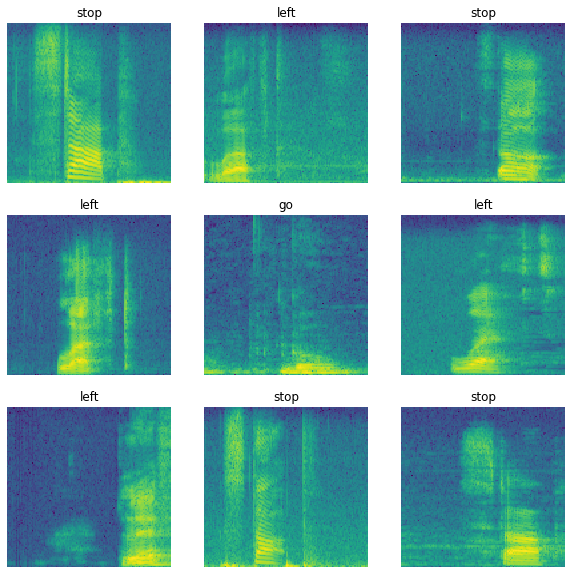

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

**Construire et former le modèle**

Vous pouvez maintenant créer et entraîner votre modèle. Mais avant cela, vous devrez répéter le prétraitement de l'ensemble d'entraînement sur les ensembles de validation et de test.

In [29]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [32]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Regroupez les ensembles de formation et de validation pour la formation de modèle.

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Ajoutez des opérations de cache() et de prefetch() ensemble de données pour réduire la latence de lecture lors de l'entraînement du modèle.

In [34]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Pour le modèle, vous utiliserez un simple réseau neuronal convolutif (CNN), puisque vous avez transformé les fichiers audio en images spectrogrammes. Le modèle comporte également les couches de prétraitement supplémentaires suivantes:

Un calque de Resizing pour sous-échantillonner l'entrée pour permettre au modèle de s'entraîner plus rapidement.
Une Normalization couche de normaliser chaque pixel de l'image en fonction de son écart moyen et standard.
Pour la couche Normalization , sa méthode d' adapt devrait d'abord être appelée sur les données d'apprentissage afin de calculer des statistiques agrégées (c'est-à-dire la moyenne et l'écart type).

In [35]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 39s 384ms/step - loss: 1.9087 - accuracy: 0.2782 - val_loss: 1.2769 - val_accuracy: 0.6012
Epoch 2/10
100/100 [==============================] - 20s 203ms/step - loss: 1.2626 - accuracy: 0.5486 - val_loss: 0.9741 - val_accuracy: 0.6750
Epoch 3/10
100/100 [==============================] - 20s 202ms/step - loss: 0.9480 - accuracy: 0.6628 - val_loss: 0.9010 - val_accuracy: 0.6963
Epoch 4/10
100/100 [==============================] - 20s 202ms/step - loss: 0.8060 - accuracy: 0.7101 - val_loss: 0.7223 - val_accuracy: 0.7638
Epoch 5/10
100/100 [==============================] - 20s 202ms/step - loss: 0.6691 - accuracy: 0.7718 - val_loss: 0.6459 - val_accuracy: 0.7875
Epoch 6/10
100/100 [==============================] - 20s 203ms/step - loss: 0.5737 - accuracy: 0.8055 - val_loss: 0.5926 - val_accuracy: 0.8050
Epoch 7/10
100/100 [==============================] - 20s 204ms/step - loss: 0.5109 - accuracy: 0.8231 - val_loss: 0.5991 - val_ac

Vérifions les courbes de perte d'entraînement et de validation pour voir comment votre modèle s'est amélioré pendant l'entraînement.

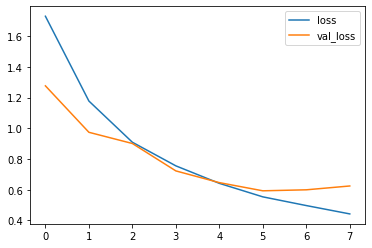

In [39]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**Évaluer les performances de l'ensemble de test**

Exécutons le modèle sur l'ensemble de test et vérifions les performances.

In [40]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [41]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


**Afficher une matrice de confusion**

Une matrice de confusion est utile pour voir dans quelle mesure le modèle a fonctionné pour chacune des commandes de l'ensemble de test.

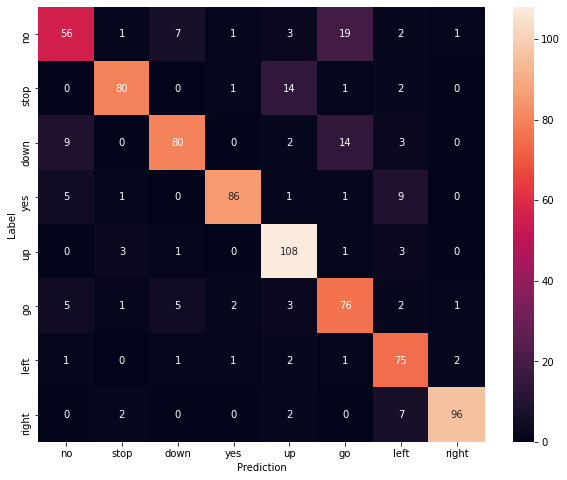

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

**Exécuter l'inférence sur un fichier audio**

Enfin, vérifiez la sortie de prédiction du modèle à l'aide d'un fichier audio d'entrée d'une personne disant «non». Dans quelle mesure votre modèle fonctionne-t-il?

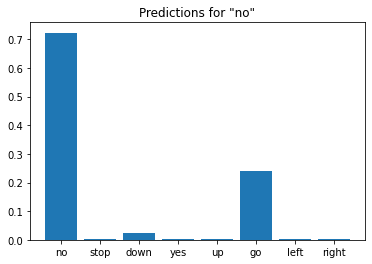

In [43]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

Vous pouvez voir que votre modèle a très clairement reconnu la commande audio comme "non".

**Prochaines étapes**

Ce didacticiel a montré comment effectuer une classification audio simple à l'aide d'un réseau neuronal convolutif avec TensorFlow et Python.

Pour apprendre à utiliser l'apprentissage par transfert pour la classification audio, consultez le didacticiel Classification des sons avec YAMNet .

Pour créer votre propre application Web interactive pour la classification audio, envisagez d' utiliser TensorFlow.js - Reconnaissance audio à l'aide du laboratoire de codage d'apprentissage par transfert .

TensorFlow prend également en charge la préparation et l'augmentation des données audio pour vous aider dans vos propres projets audio.